# Pregunta 3

### Chequeos previos de performance

Para evitar tiempos de entrenamiento muy extensos es recomendable utilizar la **GPU** disponible en el sistema en lugar de la **CPU**, ya que posee la habilidad de realizar cálculos matemáticos de manera más eficiente. A continuación se verifica que se esté efectivamente utilizando la GPU en lugar de la CPU.

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

C:\Users\Felipe\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12272592175205722246
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3178453401
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8263278684107119017
physical_device_desc: "device: 0, name: GeForce GTX 980, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


# Generación del dataset

**Nota**: No fue posible descargar el dataset desde el link propiciado en el enunciado de esta pregunta, por lo que se optó por utilizar el dataset (que se asume es análogo) desde keras.

In [2]:
from keras.datasets import cifar10
import keras
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(x_train, y_train), (x_original_test, y_original_test) = cifar10.load_data()

y_train = keras.utils.to_categorical(y_train)
y_original_test = keras.utils.to_categorical(y_original_test, num_classes=10)

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
def show(img):
    plt.imshow(img, interpolation='nearest')

### Visualización de algunos ejemplos

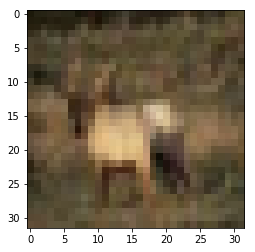

In [4]:
show(x_train[3])

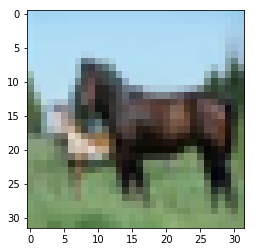

In [5]:
show(x_train[12])

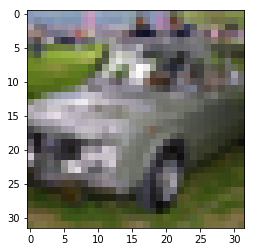

In [6]:
show(x_train[44])

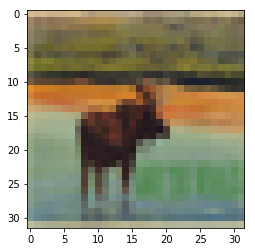

In [7]:
show(x_train[66])

# Generación de conjuntos de validación, test y entrenamiento

Se generan 3 conjuntos distintos para los experimentos a realizar en esta pregunta.

In [8]:
from sklearn.model_selection import train_test_split

x_test, x_val, y_test, y_val = train_test_split(x_original_test, y_original_test, test_size=0.5, random_state=42)

x_train = x_train/255
x_test = x_test/255
x_val = x_val/255


print("Train samples: %d" % len(x_train))
print("Test samples: %d" % len(x_test))
print("Validation samples: %d" % len(x_val))

Train samples: 50000
Test samples: 5000
Validation samples: 5000


# Cambios de dimensionalidad

A continuación se visualiza el esquema de la red neuronal convolucional a utilizar para el siguiente experimento

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

def define_convolutional(filter_size=3):
    model = Sequential()
    model.add(Conv2D(64, (filter_size, filter_size), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (filter_size, filter_size), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model
model = define_convolutional()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

Se puede notar que a medida que se propaga la información de las imágenes a través de la red, esta sufre una modificación en su representación según una serie de transformaciones denominadas convoluciones, que permite que cada neurona reciba una porción de la imágen original, y que la capa subsiguiente pueda entonces detectar características específicas es estas.

# Entrenamiento de red usando SGD

Realizamos el entrenamiento con un decay customizado definido en `step_decay`

In [28]:
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate

# Entrenamiento de la red
sgd_model = define_convolutional()
sgd = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
sgd_model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["acc"])
sgd_history = sgd_model.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test,y_test), shuffle=True, callbacks=[lrate])

Train on 50000 samples, validate on 5000 samples
Epoch 1/25
50000/50000 [==============================] - 12s 238us/step - loss: 1.8899 - acc: 0.3244 - val_loss: 1.6106 - val_acc: 0.4230
Epoch 2/25
50000/50000 [==============================] - 11s 224us/step - loss: 1.5008 - acc: 0.4674 - val_loss: 1.3883 - val_acc: 0.5086
Epoch 3/25
50000/50000 [==============================] - 11s 222us/step - loss: 1.3348 - acc: 0.5254 - val_loss: 1.2833 - val_acc: 0.5362
Epoch 4/25
50000/50000 [==============================] - 11s 223us/step - loss: 1.2257 - acc: 0.5687 - val_loss: 1.2375 - val_acc: 0.5580
Epoch 5/25
50000/50000 [==============================] - 11s 222us/step - loss: 1.1144 - acc: 0.6111 - val_loss: 1.1292 - val_acc: 0.6064
Epoch 6/25
50000/50000 [==============================] - 11s 222us/step - loss: 1.0640 - acc: 0.6285 - val_loss: 1.0725 - val_acc: 0.6280
Epoch 7/25
50000/50000 [==============================] - 11s 223us/step - loss: 1.0187 - acc: 0.6478 - val_loss: 1.0

### Resultados

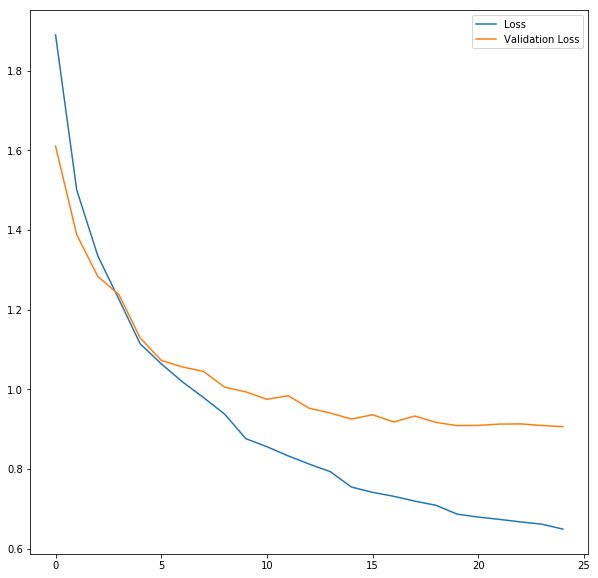

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(range(0, len(sgd_history.history["loss"])), sgd_history.history["loss"], label="Loss")
plt.plot(range(0, len(sgd_history.history["val_loss"])), sgd_history.history["val_loss"], label="Validation Loss")
    
plt.legend()
#plt.xlim(-2, 45)
plt.show()

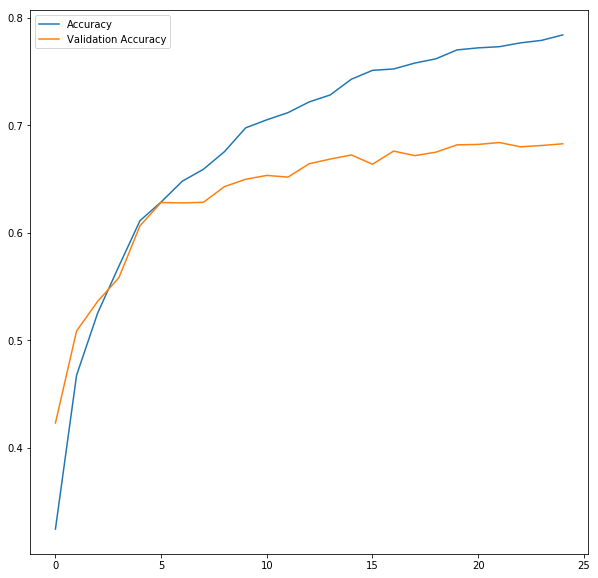

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(range(0, len(sgd_history.history["acc"])), sgd_history.history["acc"], label="Accuracy")
plt.plot(range(0, len(sgd_history.history["val_acc"])), sgd_history.history["val_acc"], label="Validation Accuracy")
    
plt.legend()
#plt.xlim(-2, 45)
plt.show()

Como se puede observar en los gráficos, tanto el error de entrenamiento como de testing logran converger a medida que transcurren las épocas correspondientes.

# Entrenamiento de red utilizando RMSProp

In [31]:
from keras.optimizers import SGD, rmsprop
rmsprop_model = define_convolutional()
opt = rmsprop(lr=0.001, decay=1e-6)
rmsprop_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])
rmsprop_history = rmsprop_model.fit(x_train, y_train,batch_size=32,epochs=25, validation_data=(x_test, y_test),shuffle=True)

Train on 50000 samples, validate on 5000 samples
Epoch 1/25
50000/50000 [==============================] - 13s 270us/step - loss: 1.3586 - acc: 0.5179 - val_loss: 1.2036 - val_acc: 0.5844
Epoch 2/25
50000/50000 [==============================] - 13s 260us/step - loss: 0.9540 - acc: 0.6687 - val_loss: 0.9791 - val_acc: 0.6642
Epoch 3/25
50000/50000 [==============================] - 13s 258us/step - loss: 0.7938 - acc: 0.7301 - val_loss: 0.9800 - val_acc: 0.6734
Epoch 4/25
50000/50000 [==============================] - 13s 261us/step - loss: 0.6765 - acc: 0.7699 - val_loss: 0.9952 - val_acc: 0.6740
Epoch 5/25
50000/50000 [==============================] - 13s 260us/step - loss: 0.5842 - acc: 0.8052 - val_loss: 0.9960 - val_acc: 0.6838
Epoch 6/25
50000/50000 [==============================] - 13s 259us/step - loss: 0.5022 - acc: 0.8349 - val_loss: 1.0922 - val_acc: 0.7176
Epoch 7/25
50000/50000 [==============================] - 13s 262us/step - loss: 0.4302 - acc: 0.8579 - val_loss: 1.1

### Resultados

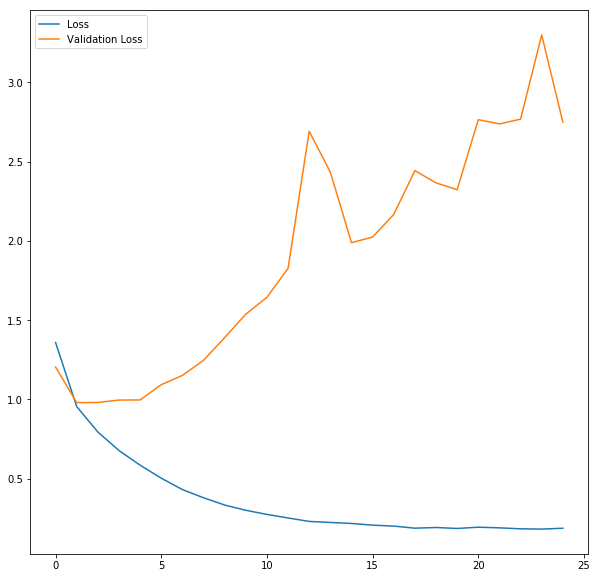

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(range(0, len(rmsprop_history.history["loss"])), rmsprop_history.history["loss"], label="Loss")
plt.plot(range(0, len(rmsprop_history.history["val_loss"])), rmsprop_history.history["val_loss"], label="Validation Loss")
    
plt.legend()
#plt.xlim(-2, 45)
plt.show()


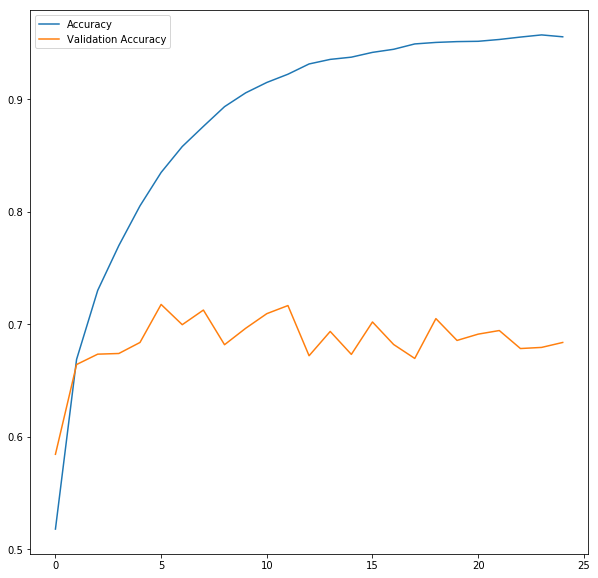

Error de test 0.6838


In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(range(0, len(rmsprop_history.history["acc"])), rmsprop_history.history["acc"], label="Accuracy")
plt.plot(range(0, len(rmsprop_history.history["val_acc"])), rmsprop_history.history["val_acc"], label="Validation Accuracy")
    
plt.legend()
#plt.xlim(-2, 45)
plt.show()
print("Error de test", rmsprop_history.history["val_acc"][-1])

Se puede observar que en este caso, la red neuronal tiene un error de entrenamiento menor que la red neuronal con SGD, pero el error de testing se mantiene constante. Esto se podría mejorar si la resolución de los datos de entrenamiento y testing fuese mejor, y se puede concluir que existe un error de testing fijo que depende de la calidad de los datos de entrada.

# Efecto del tamaño de los filtros de convolución

In [12]:
def define_shallow_convolutional(filter_size=3):
    model = Sequential()
    model.add(Conv2D(64, (filter_size, filter_size), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

In [13]:
import numpy as np

filter_results = {
    "shallow": [],
    "deep": []
}

filter_sizes = range(2, 9)

for filter_size in filter_sizes:
    print("Training with filter size %d" % filter_size)
    # Use the shallow first
    model = define_shallow_convolutional(filter_size=filter_size)
    model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["acc"])
    history = model.fit(x_train, y_train,batch_size=32,epochs=20, validation_data=(x_test, y_test),shuffle=True, verbose=False)
    filter_results["shallow"].append(history)
    
    # Deep one
    model = define_convolutional(filter_size=filter_size)
    model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["acc"])
    history = model.fit(x_train, y_train,batch_size=32,epochs=20, validation_data=(x_test, y_test),shuffle=True, verbose=False)
    filter_results["deep"].append(history)

Training with filter size 2
Training with filter size 3
Training with filter size 4
Training with filter size 5
Training with filter size 6
Training with filter size 7
Training with filter size 8


### Resultados para red shallow

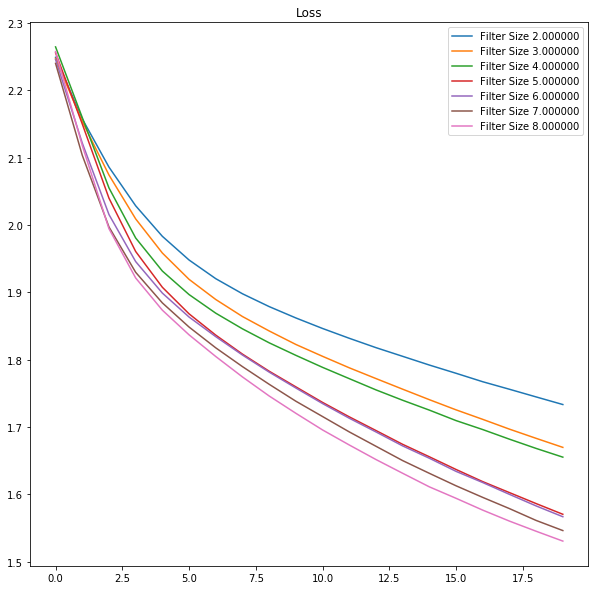

In [37]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for filter_size in filter_sizes:
    res = filter_results["shallow"][counter]
    plt.plot(range(0, len(res.history["loss"])), res.history["loss"], label="Filter Size %f" % (filter_size))
    counter += 1
    
plt.legend()
plt.title('Loss')
#plt.xlim(-2, 45)
plt.show()

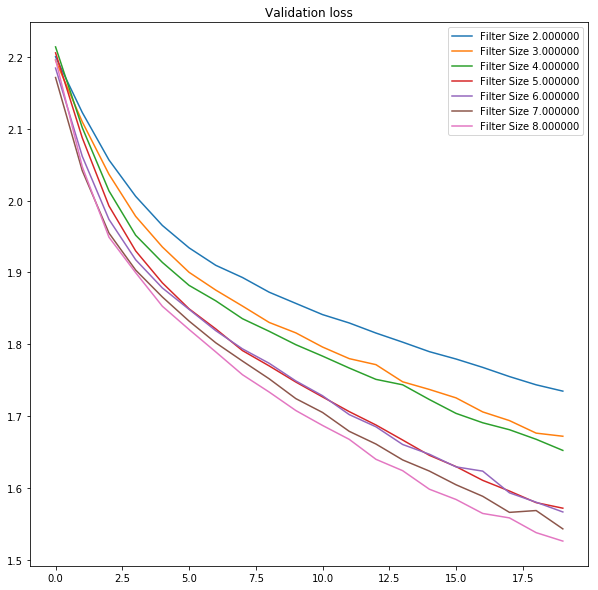

In [38]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for filter_size in filter_sizes:
    res = filter_results["shallow"][counter]
    plt.plot(range(0, len(res.history["val_loss"])), res.history["val_loss"], label="Filter Size %f" % (filter_size))
    counter += 1
    
plt.legend()
plt.title('Validation loss')
#plt.xlim(-2, 45)
plt.show()

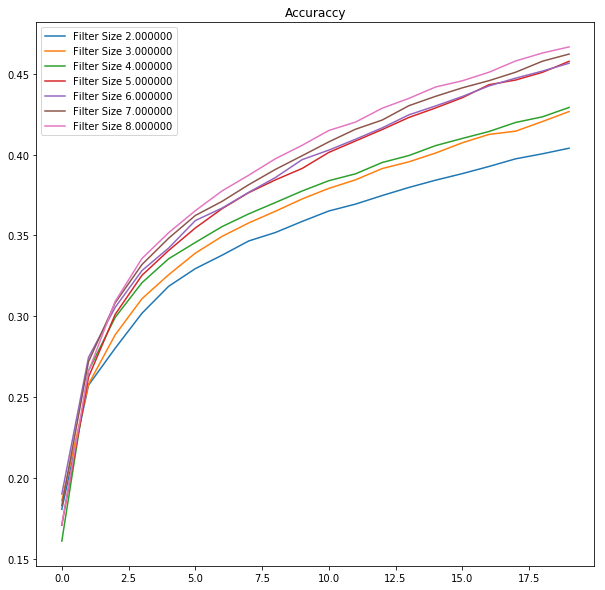

In [39]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for filter_size in filter_sizes:
    res = filter_results["shallow"][counter]
    plt.plot(range(0, len(res.history["acc"])), res.history["acc"], label="Filter Size %f" % (filter_size))
    counter += 1
    
plt.legend()
plt.title('Accuraccy')
#plt.xlim(-2, 45)
plt.show()

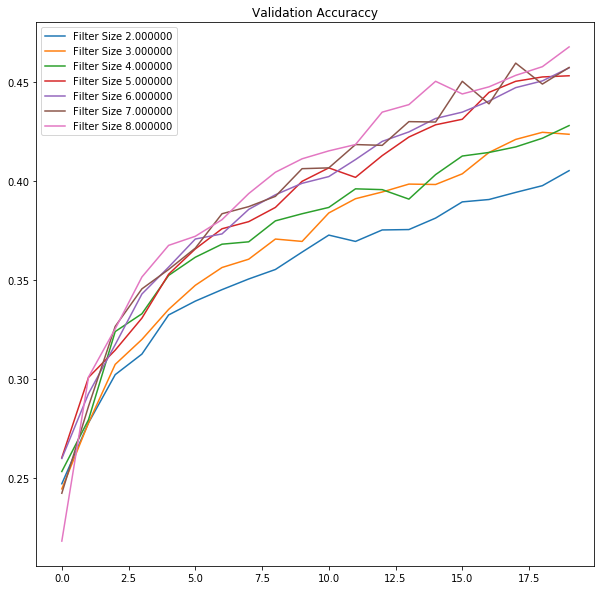

In [40]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for filter_size in filter_sizes:
    res = filter_results["shallow"][counter]
    plt.plot(range(0, len(res.history["val_acc"])), res.history["val_acc"], label="Filter Size %f" % (filter_size))
    counter += 1
    
plt.legend()
plt.title('Validation Accuraccy')
#plt.xlim(-2, 45)
plt.show()

Como se puede observar, a medida que aumenta el tamaño de filtros de convolución, mayor es el accuracy de la red neurnal. Esto se explica por el hecho de que con filtros de mayor tamaño, la red neuronal tiene un "field of view" mucho mayor por cada neurona en la capa de convolución, lo que le permite identificar características más generales de las entidades que se encuentra en la foto.

### Resultados para red deep

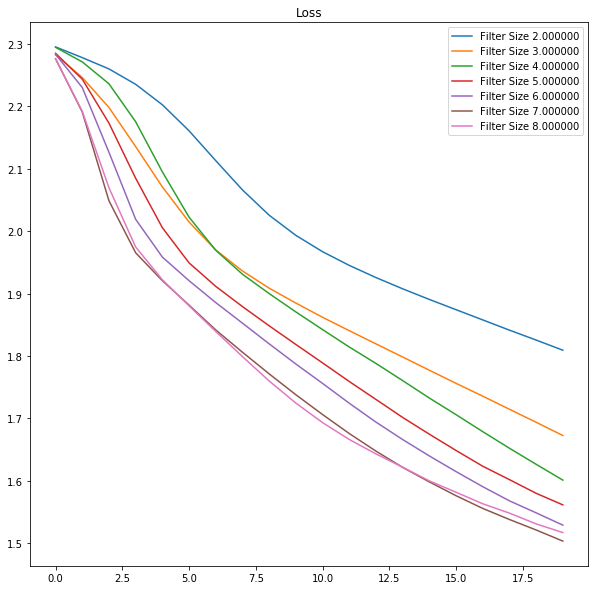

In [41]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for filter_size in filter_sizes:
    res = filter_results["deep"][counter]
    plt.plot(range(0, len(res.history["loss"])), res.history["loss"], label="Filter Size %f" % (filter_size))
    counter += 1
    
plt.legend()
plt.title('Loss')
#plt.xlim(-2, 45)
plt.show()

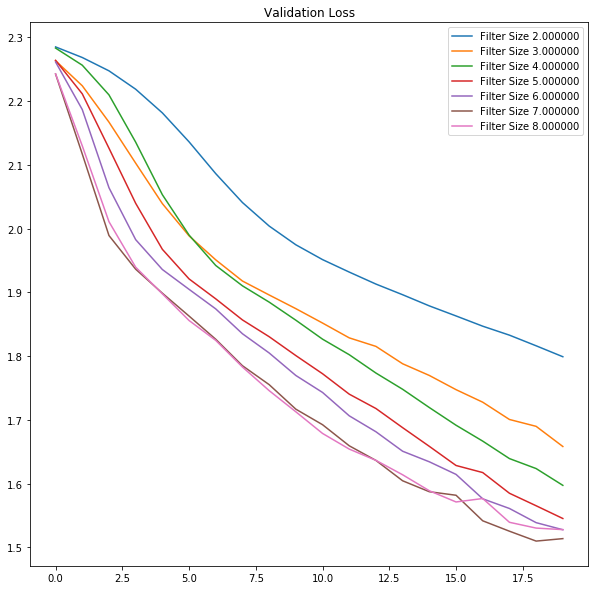

In [42]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for filter_size in filter_sizes:
    res = filter_results["deep"][counter]
    plt.plot(range(0, len(res.history["val_loss"])), res.history["val_loss"], label="Filter Size %f" % (filter_size))
    counter += 1
    
plt.legend()
plt.title('Validation Loss')
#plt.xlim(-2, 45)
plt.show()

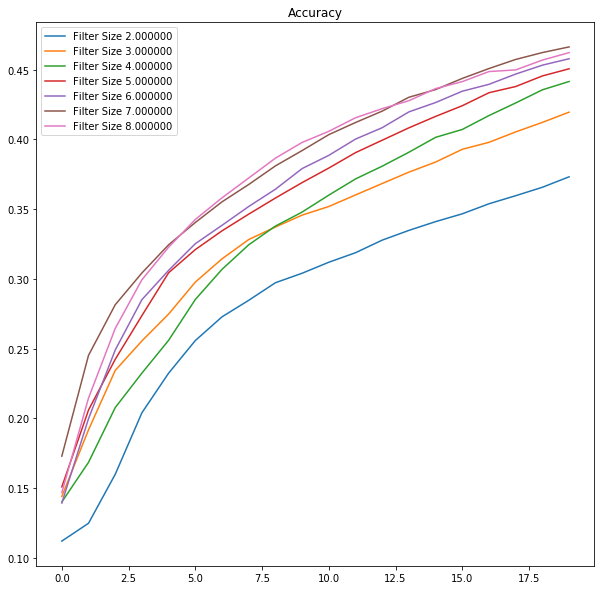

In [44]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for filter_size in filter_sizes:
    res = filter_results["deep"][counter]
    plt.plot(range(0, len(res.history["acc"])), res.history["acc"], label="Filter Size %f" % (filter_size))
    counter += 1
    
plt.legend()
plt.title('Accuracy')
#plt.xlim(-2, 45)
plt.show()

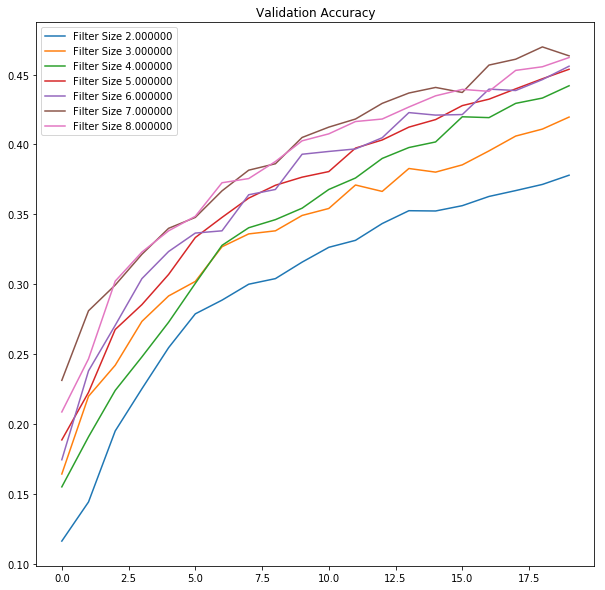

In [45]:
import matplotlib.pyplot as plt

counter = 0
plt.figure(figsize=(10, 10))
for filter_size in filter_sizes:
    res = filter_results["deep"][counter]
    plt.plot(range(0, len(res.history["val_acc"])), res.history["val_acc"], label="Filter Size %f" % (filter_size))
    counter += 1
    
plt.legend()
plt.title('Validation Accuracy')
#plt.xlim(-2, 45)
plt.show()

En la red neuronal profunda sucede el mismo comportamiento lineal entre el tamaño de los filtros y el accuracy de testing.

Es posible concluir que un tamaño mayor de filtros de convolución es mejor cuando este es relativamente pequeño en comparación al tamaño de las imágenes de entrada. Utilizar filtros de un tamaño igual al tamaño de la imágen es ineficiente ya que no permitirá que la red neuronal pueda tomar ventaja de la convolución, y es además computacionalmente infactible considerando las limitaciones de memoria y la gran cantidad de parámetros que se debe optimizar con un número mayor de filtros.

Por último, es relevante observar que la red neuronal shallow tiene un mejor coportamiento que la profunda en este caso, auqneu dicha comparación es relativamente injusta considerando que la red neuronal profunda puede llegar a tener mejor performance con un número de epochs mayor.

# Doble capa de convolución

In [18]:
def define_convolutional_for_g():
    model = Sequential()
    
    # C
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    
    # C
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    
    # P
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
     # C
    model.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    
    # C
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    
    # P
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    
    # F
    model.add(Dense(512))
    model.add(Activation('relu'))
    
    # F
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

define_convolutional_for_g().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_62 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_63 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 128)       73856     
__________

In [46]:
double_model = define_convolutional_for_g()
opt = rmsprop(lr=0.001, decay=1e-6)
double_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])
double_history = double_model.fit(x_train, y_train,batch_size=32,epochs=25, validation_data=(x_test, y_test),shuffle=True)

Train on 50000 samples, validate on 5000 samples
Epoch 1/25
50000/50000 [==============================] - 24s 484us/step - loss: 1.4027 - acc: 0.4997 - val_loss: 1.0720 - val_acc: 0.6258
Epoch 2/25
50000/50000 [==============================] - 23s 466us/step - loss: 0.8931 - acc: 0.6912 - val_loss: 1.0298 - val_acc: 0.6348
Epoch 3/25
50000/50000 [==============================] - 23s 465us/step - loss: 0.7375 - acc: 0.7492 - val_loss: 0.8666 - val_acc: 0.7310
Epoch 4/25
50000/50000 [==============================] - 23s 464us/step - loss: 0.6713 - acc: 0.7793 - val_loss: 0.7975 - val_acc: 0.7316
Epoch 5/25
50000/50000 [==============================] - 23s 465us/step - loss: 0.6354 - acc: 0.7932 - val_loss: 0.9720 - val_acc: 0.6882
Epoch 6/25
50000/50000 [==============================] - 23s 465us/step - loss: 0.6288 - acc: 0.7996 - val_loss: 1.2533 - val_acc: 0.6700
Epoch 7/25
50000/50000 [==============================] - 23s 465us/step - loss: 0.6146 - acc: 0.8032 - val_loss: 1.1

### Resultados

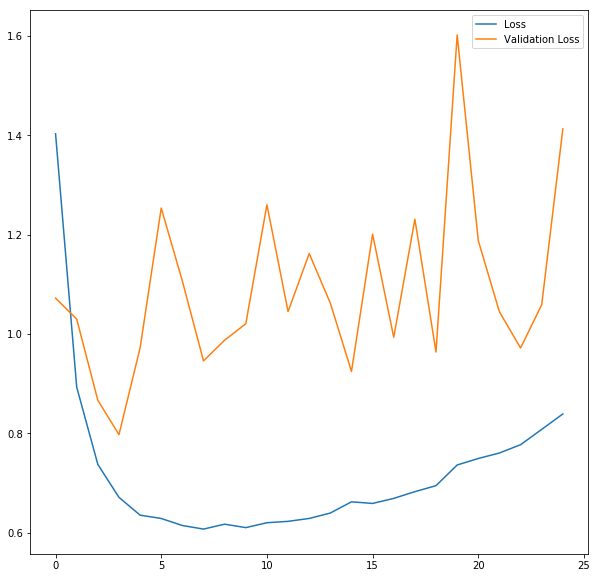

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(range(0, len(double_history.history["loss"])), double_history.history["loss"], label="Loss")
plt.plot(range(0, len(double_history.history["val_loss"])), double_history.history["val_loss"], label="Validation Loss")
    
plt.legend()
#plt.xlim(-2, 45)
plt.show()

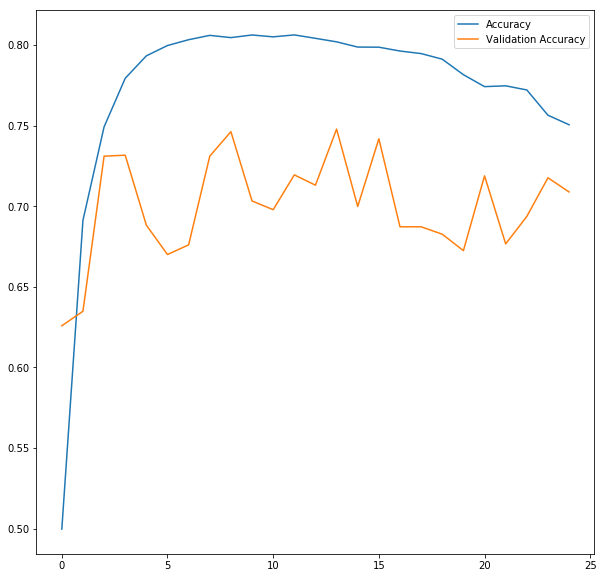

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(range(0, len(double_history.history["acc"])), double_history.history["acc"], label="Accuracy")
plt.plot(range(0, len(double_history.history["val_acc"])), double_history.history["val_acc"], label="Validation Accuracy")
    
plt.legend()
#plt.xlim(-2, 45)
plt.show()

Como se puede observar en el gráfico, el error de testing llegar a un accuracy mayor al 70% antes de las 5 epochs. Por tanto, se puede concluir que converge más rápido. De todas formas, esta arquitectura es más sensible al overfitting, tal y como se puede bservar en las epochs más avanzadas.

En este caso, sería mejor utilizar filtros más pequeños que las capas iniciales para permitirle a la red neuronal explorar características específicas de las características que estaba analizando previamente. Por ejemplo, si una de las capas de convolución realiza un filtro horizontal a una imágen, podría ser interezante realizar un segundo filtro horizontal, específico o customizado a dicha capa.

# Utilización de convolución con strides

In [20]:
def define_convolutional_for_h():
    model = Sequential()
    
    # C
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    
    # C
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    
    # C_STRIDE
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    
     # C
    model.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    
    # C
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    
    # C_STRIDE
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(Flatten())
    
    # F
    model.add(Dense(512))
    model.add(Activation('relu'))
    
    # F
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model
define_convolutional_for_h().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_74 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_75 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
activation_76 (Activation)   (None, 16, 16, 128)       0         
__________

Como se puede observar, no hay una reducción de dimensionalidad en comparación con la red de convolución con doble capa

In [22]:
strides_model = define_convolutional_for_h()
opt = rmsprop(lr=0.001, decay=1e-6)
strides_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])
strides_history = strides_model.fit(x_train, y_train,batch_size=32,epochs=25, validation_data=(x_test, y_test),shuffle=True)

Train on 50000 samples, validate on 5000 samples
Epoch 1/25
50000/50000 [==============================] - 28s 562us/step - loss: 1.5530 - acc: 0.4426 - val_loss: 1.2569 - val_acc: 0.5600
Epoch 2/25
50000/50000 [==============================] - 27s 549us/step - loss: 0.9645 - acc: 0.6660 - val_loss: 0.8907 - val_acc: 0.6946
Epoch 3/25
50000/50000 [==============================] - 27s 549us/step - loss: 0.7507 - acc: 0.7440 - val_loss: 0.9602 - val_acc: 0.6920
Epoch 4/25
50000/50000 [==============================] - 27s 548us/step - loss: 0.5877 - acc: 0.8003 - val_loss: 1.0119 - val_acc: 0.7064
Epoch 5/25
50000/50000 [==============================] - 27s 549us/step - loss: 0.4445 - acc: 0.8535 - val_loss: 1.2448 - val_acc: 0.6948
Epoch 6/25
50000/50000 [==============================] - 28s 551us/step - loss: 0.3512 - acc: 0.8855 - val_loss: 1.6120 - val_acc: 0.6652
Epoch 7/25
50000/50000 [==============================] - 27s 549us/step - loss: 0.2835 - acc: 0.9121 - val_loss: 1.4

### Resultados

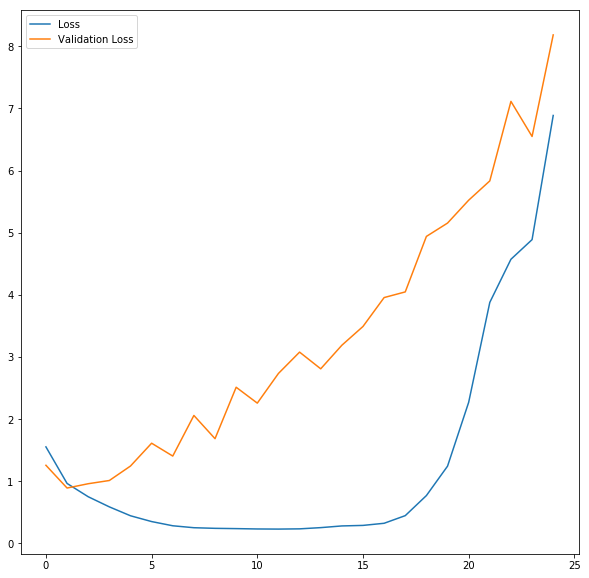

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(range(0, len(strides_history.history["loss"])), strides_history.history["loss"], label="Loss")
plt.plot(range(0, len(strides_history.history["val_loss"])), strides_history.history["val_loss"], label="Validation Loss")
    
plt.legend()
#plt.xlim(-2, 45)
plt.show()

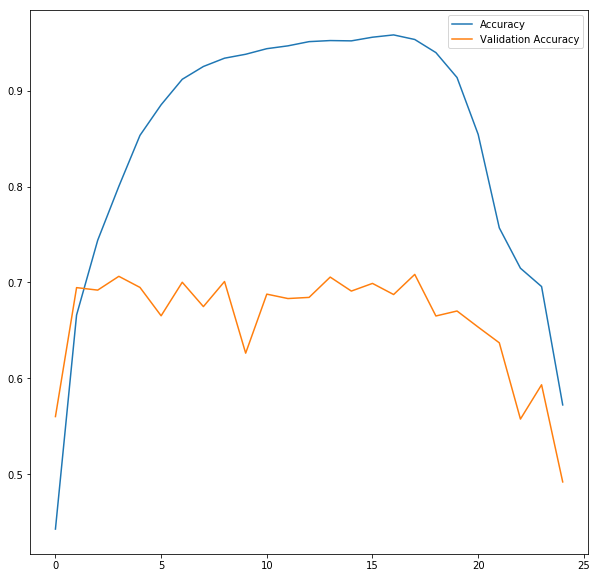

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(range(0, len(strides_history.history["acc"])), strides_history.history["acc"], label="Accuracy")
plt.plot(range(0, len(strides_history.history["val_acc"])), strides_history.history["val_acc"], label="Validation Accuracy")
    
plt.legend()
#plt.xlim(-2, 45)
plt.show()

La red neuronal logra su mayor accuracy de forma casi instantánea. Sin embargo, el overfitting que se produce es bastante notorio a partir del epoch 17.

# Generación de suconjuntos con movimientos

La manipulación de las imágenes originales a través de rotaciones y traslaciones en distintos ejes podría ser pensada como una forma de aumentar la cantidad de ejemplos de entrenamiento. En esta sección, se comprueba de manera empírica si su incorporación es de ayuda o no

In [23]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(x_train)


movements_model = define_convolutional()
opt = rmsprop(lr=0.001, decay=1e-6)
movements_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

batch_size = 32
history_movements = movements_model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),steps_per_epoch=x_train.shape[0]// batch_size, epochs=25,validation_data=(x_test, y_test))

Epoch 1/25
1562/1562 [==============================] - 18s 11ms/step - loss: 1.4606 - acc: 0.4776 - val_loss: 1.1987 - val_acc: 0.5734
Epoch 2/25
1562/1562 [==============================] - 17s 11ms/step - loss: 1.1288 - acc: 0.6056 - val_loss: 0.9709 - val_acc: 0.6586
Epoch 3/25
1562/1562 [==============================] - 17s 11ms/step - loss: 1.0337 - acc: 0.6410 - val_loss: 0.9802 - val_acc: 0.6784
Epoch 4/25
1562/1562 [==============================] - 17s 11ms/step - loss: 0.9856 - acc: 0.6630 - val_loss: 0.9843 - val_acc: 0.6758
Epoch 5/25
1562/1562 [==============================] - 17s 11ms/step - loss: 0.9543 - acc: 0.6735 - val_loss: 0.9229 - val_acc: 0.6954
Epoch 6/25
1562/1562 [==============================] - 17s 11ms/step - loss: 0.9404 - acc: 0.6843 - val_loss: 1.0180 - val_acc: 0.6580
Epoch 7/25
1562/1562 [==============================] - 17s 11ms/step - loss: 0.9288 - acc: 0.6885 - val_loss: 0.8201 - val_acc: 0.7350
Epoch 8/25
1562/1562 [==========================

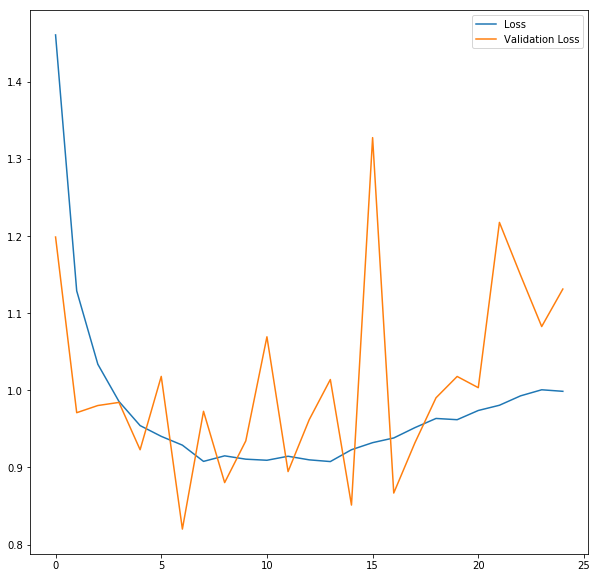

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(range(0, len(history_movements.history["loss"])), history_movements.history["loss"], label="Loss")
plt.plot(range(0, len(history_movements.history["val_loss"])), history_movements.history["val_loss"], label="Validation Loss")
    
plt.legend()
#plt.xlim(-2, 45)
plt.show()

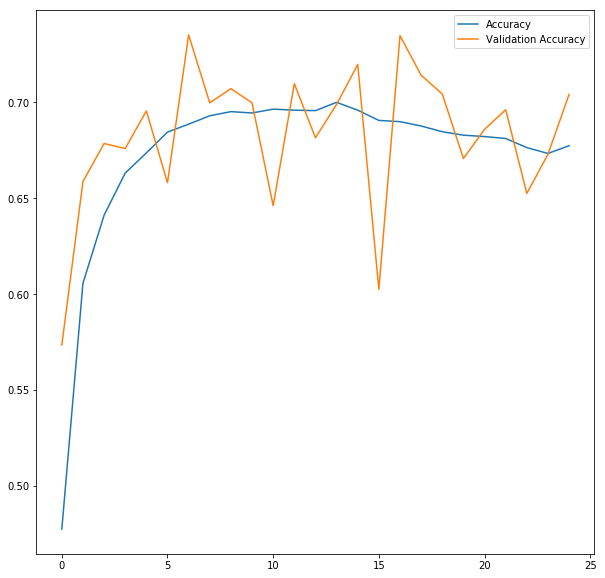

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(range(0, len(history_movements.history["acc"])), history_movements.history["acc"], label="Accuracy")
plt.plot(range(0, len(history_movements.history["val_acc"])), history_movements.history["val_acc"], label="Validation Accuracy")
    
plt.legend()
#plt.xlim(-2, 45)
plt.show()

Como se puede observar en los gráficos, se tiene que el error de testing tiende a fluctuar de manera muy agresiva en comparación a la convergencia del error de entrenamiento. Esto es esperable puesto que el conjunto de testing no posee imágenes que hayan experimentado traslaciones o rotaciones y no se comporta como un conjunto representativo de lo que se está entrenando.

Aún así, el error de testing logra un accuracy mayor en comparación a las redes neuronales anteriores (esto en epochs específicos) debido a que la incorporación de traslaciones y rotaciones permite robustecer el modelo, ya que le permit reconocer patrones aún cuando las entidades que se desean clasificar aparezcan con dichas rotaciones, lo cual es muy probable si se quiere llevar esto a un problema de visión computacional.

# Matriz de confusión de red neuronal

In [26]:
from keras.optimizers import SGD, rmsprop
matrix_model = define_convolutional()
opt = rmsprop(lr=0.001, decay=1e-6)
matrix_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])
history = matrix_model.fit(x_train, y_train,batch_size=32,epochs=25, validation_data=(x_test, y_test),shuffle=True)

Train on 50000 samples, validate on 5000 samples
Epoch 1/25
50000/50000 [==============================] - 14s 270us/step - loss: 1.3572 - acc: 0.5194 - val_loss: 1.1644 - val_acc: 0.5862
Epoch 2/25
50000/50000 [==============================] - 13s 261us/step - loss: 0.9529 - acc: 0.6690 - val_loss: 1.0661 - val_acc: 0.6274
Epoch 3/25
50000/50000 [==============================] - 13s 256us/step - loss: 0.7896 - acc: 0.7318 - val_loss: 1.0975 - val_acc: 0.6498
Epoch 4/25
50000/50000 [==============================] - 13s 258us/step - loss: 0.6711 - acc: 0.7714 - val_loss: 0.9571 - val_acc: 0.6998
Epoch 5/25
50000/50000 [==============================] - 13s 255us/step - loss: 0.5700 - acc: 0.8088 - val_loss: 1.0005 - val_acc: 0.7058
Epoch 6/25
50000/50000 [==============================] - 13s 254us/step - loss: 0.4887 - acc: 0.8372 - val_loss: 1.0178 - val_acc: 0.7148
Epoch 7/25
50000/50000 [==============================] - 13s 253us/step - loss: 0.4196 - acc: 0.8621 - val_loss: 1.2

Confusion matrix, without normalization
[[299  20  37  12  43   8   3  11  26  20]
 [  6 413   2   5   5   2   5   2  12  34]
 [ 19   2 335  24  62  33  25  13   8   4]
 [  6  10  32 261  59  80  32   9   1  10]
 [  3   4  19  36 385  24  15  18   1   1]
 [  1   1  21  71  39 310  14  13   3   5]
 [  2   4  21  42  31  15 391   0   2   3]
 [  3   3  16  22  63  32   3 375   2   9]
 [ 24  22   9   9  15   6   2   4 387  11]
 [  9  41   2  10  12   7   2   7  13 395]]


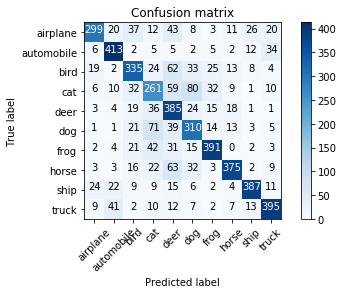

In [27]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_hat = matrix_model.predict(x_val)

def onehot_to_number(x):
    return np.argmax(x)


y_hat_number = list(map(lambda elem: onehot_to_number(elem), y_hat))
y_val_number = list(map(lambda elem: onehot_to_number(elem), y_val))



    
matrix = confusion_matrix(y_val_number, y_hat_number)
plot_confusion_matrix(matrix, label_names)

plt.show()

Como se puede observar en la matriz de confusión, la red neuronal seleccionada está teniendo mayores problemas en clasificar entidades que son similares entre sí. Por ejemplo, le cuesta más clasificar imágenes entre venados y caballos. Esto tiene mucho sentido considerando que ambos animales tienen caractrísticas muy similares entre sí. Es más, como se puedo observar anteriormente, las imágenes tienen bastante poca calidad, lo que hace difícil distinguir entre algunas entidaes incluso para los humanos. Por tanto, este tipo de errores es bastante comprensible.

El único error que no es aceptable es la confusión que tiene la red neuronal entre aviones y venados, ya que son entidades completamente distintas entre sí.

# Visualización de gradientes

In [55]:
import seaborn
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import keras
from keras import backend as K
import tensorflow as tf

# Definición del modelo
gradient_model = define_convolutional()
opt = rmsprop(lr=0.001, decay=1e-6)
gradient_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

# Cálculo de las gradientes
loss = keras.losses.mean_squared_error(gradient_model.output,y_train)
listOfVariableTensors = gradient_model.trainable_weights
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={gradient_model.input:x_train})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]


for i in range(0, len(evaluated_gradients) + 1, 2):
    layers_before.append({
        "weights": [item for sublist in evaluated_gradients[i] for item in sublist],
    })


history = matrix_model.fit(x_train, y_train,batch_size=32,epochs=25, validation_data=(x_test, y_test),shuffle=True)

# Cálculo de las gradientes
loss = keras.losses.mean_squared_error(gradient_model.output,y_train)
listOfVariableTensors = gradient_model.trainable_weights
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={gradient_model.input:x_train})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

for i in range(0, len(evaluated_gradients) + 1, 2):
    layers_after.append({
        "weights": [item for sublist in evaluated_gradients[i] for item in sublist],
    })

ResourceExhaustedError: OOM when allocating tensor with shape[50000,64,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_72/convolution = Conv2D[T=DT_FLOAT, _class=["loc:@gradients_2/conv2d_72/convolution_grad/Conv2DBackpropFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_72/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_72/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: gradients_2/conv2d_73/convolution_grad/Conv2DBackpropFilter/_3099 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_156_gradients_2/conv2d_73/convolution_grad/Conv2DBackpropFilter", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv2d_72/convolution', defined at:
  File "C:\Users\Felipe\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Felipe\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-cb82de5e6799>", line 10, in <module>
    gradient_model = define_convolutional()
  File "<ipython-input-9-eba04d780a37>", line 7, in define_convolutional
    model.add(Conv2D(64, (filter_size, filter_size), padding='same', input_shape=x_train.shape[1:]))
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\keras\models.py", line 467, in add
    layer(x)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\keras\layers\convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 3335, in conv2d
    data_format=tf_data_format)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 780, in convolution
    return op(input, filter)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 204, in __call__
    name=self.name)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1042, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "C:\Users\Felipe\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[50000,64,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_72/convolution = Conv2D[T=DT_FLOAT, _class=["loc:@gradients_2/conv2d_72/convolution_grad/Conv2DBackpropFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_72/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_72/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: gradients_2/conv2d_73/convolution_grad/Conv2DBackpropFilter/_3099 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_156_gradients_2/conv2d_73/convolution_grad/Conv2DBackpropFilter", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
import seaborn
import matplotlib.pyplot as plt

total = len(layers_before["weights"])

# Flatten the list
fig, axes = plt.subplots(nrows=total, ncols=2, figsize=(13, 30))

for n in range(0, total):
    axes[n, 0].set_title("Layer %d - Weights - Before" % n+1)
    seaborn.distplot(layers_before[n]["weights"], label="0", ax=axes[n, 0])
    
    axes[n, 0].set_title("Layer %d - Weights - After" % n+1)
    seaborn.distplot(layers_after[n]["weights"], label="0", ax=axes[n, 0])
plt.show()